In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# utils

In [85]:
def alpha_transform(data: pd.DataFrame, col: str, max_value: float):
    data = data.reset_index().set_index("date")
    data["mean"] = data.groupby("date")[col].mean()
    data["std"] = data.groupby("date")[col].std()
    data["zscore"] = np.minimum(max_value,np.maximum(-max_value,(data[col] - data["mean"]) / data["std"])).fillna(0)
    data = data.reset_index().set_index(['date', 'permno'])
    return data["zscore"]


def feature_clip(x, col, qmin, qmax):
    return x[col].clip(x[col].quantile(qmin),x[col].quantile(qmax))


def get_quantile_returns(frame, signal_col, n_bins, ret):
    frame[f'{signal_col}Group'] = pd.qcut(frame[signal_col], n_bins, labels=[i + 1 for i in range(n_bins)])
    return frame.groupby(f'{signal_col}Group')[ret].mean()


def get_long_only_returns(frame, signal_col, perc, ret):
    edge = frame[signal_col].quantile(1-perc)
    return frame[frame[signal_col] > edge][ret].mean()


def get_long_only_weight(frame, signal_col, nbins):
    label = frame.groupby('date')[signal_col].transform(lambda x: pd.qcut(x, nbins, labels=range(1, nbins+1))).to_frame()
    label.columns = ['label']
    cnts = label.groupby('date')['label'].transform(lambda x: (x==nbins).sum())
    label = label.join(frame['future_ret'])
    label['weight'] = 0
    label.loc[label['label']==nbins, 'weight'] = 1/cnts
    return label[['weight', 'future_ret']].dropna(subset=['future_ret'])


def get_long_short_returns(frame, signal_col, perc, ret):
    edge_short = frame[signal_col].quantile(perc)
    edge_long = frame[signal_col].quantile(1-perc)
    return frame[frame[signal_col] > edge_long][ret].mean() - frame[frame[signal_col] <= edge_short][ret].mean()


def get_long_short_weight(frame, signal_col, perc, ret):
    edge_short = frame[signal_col].quantile(perc)
    edge_long = frame[signal_col].quantile(1-perc)
    cnt_long = frame[frame[signal_col] > edge_long].shape[0]
    cnt_short = frame[frame[signal_col] <= edge_short].shape[0]
    frame['weight'] = 0
    frame[frame[signal_col] > edge, 'weight'] = 1/cnt_long
    frame[frame[signal_col] <= edge, 'weight'] = 1/cnt_short
    return frame['weight']


def backtest(daily_ret: pd.DataFrame, name: str):
    start_date = daily_ret.index[0].date()
    end_date = daily_ret.index[-1].date()
    ret = daily_ret.mean() * 4
    std = daily_ret.std() * np.sqrt(4)
    n_date = daily_ret.shape[0]
    n_pos_date = (daily_ret>0).sum()
    mdd = (daily_ret.cumsum().cummax() - daily_ret.cumsum()).max()
    sharp = ret / std
    stats_dict = { 'start_date' : start_date,
                   'end_date': end_date,
                   'n_quarter': n_date,
                   'n_pos_quarter' : n_pos_date,
                   'ret_annual': ret,
                   'std_annual': std,
                   'shape': sharp,
                   'mdd': mdd}
    stats = pd.DataFrame(stats_dict)
    return stats

## Get data

In [86]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = '../data/hf_netflow.parquet.gzip'

# Read the Parquet file using pyarrow
net_flow = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
net_flow = net_flow.to_pandas()

net_flow.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2015-03-31,127.0,"AEW CAPITAL MANAGEMENT, L.P.",False,False,4553.577546,-0.097883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-06-30,127.0,"AEW CAPITAL MANAGEMENT, L.P.",False,False,4102.561959,0.036171,4051.512488,0.000000,146.225932,0.036092,-5.295758,0.000000,0.001163,0.888580
2,2015-09-30,127.0,"AEW CAPITAL MANAGEMENT, L.P.",False,False,4064.568036,0.084079,136.028707,411.538853,-22.560811,-0.041202,-186.386535,0.033311,0.078589,0.088038
3,2015-12-31,127.0,"AEW CAPITAL MANAGEMENT, L.P.",False,False,4502.353836,0.060149,641.889624,270.084462,42.346158,0.046434,96.041597,0.063053,0.090077,0.200743
4,2016-03-31,127.0,"AEW CAPITAL MANAGEMENT, L.P.",False,False,4568.146306,0.046889,59.260200,189.999783,-4.934305,-0.019796,-205.019623,0.013067,0.058698,0.009826


In [87]:
# Specify the path to your parquet.gzip file
parquet_file_path = '../data/holdings_all_hf.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

# merge with net flow
# holdings.rename(columns = {'date': 'rdate'}, inplace=True)
# holdings = holdings.merge(net_flow[['rdate', 'mgrno', 'assets']], on=['rdate', 'mgrno'], how='left')

# set index
holdings = holdings.reset_index().set_index(['date', 'mgrno', 'permno']).sort_index()

holdings.head()

first_report  last_report     shares  shares_adj  \
date       mgrno permno                                                     
2015-06-30 127.0 12756          False        False  1792286.0   1792286.0   
                 14037          False        False  3373100.0   3373100.0   
                 14061          False        False  1029700.0   1029700.0   
                 15052          False        False  1701800.0   1701800.0   
                 15194          False        False   439300.0    439300.0   

                           phrdate  pshares_adj     trade  qtrgap  lpermno  \
date       mgrno permno                                                      
2015-06-30 127.0 12756  2015-03-31    1771986.0   20300.0     1.0  12513.0   
                 14037  2015-03-31    3082300.0  290800.0     1.0  14036.0   
                 14061  2015-03-31     978300.0   51400.0     1.0  14039.0   
                 15052  2015-03-31    1195300.0  506500.0     1.0  15048.0   
                 15194  2015-03-31     576000.0 -136700.0     1.0  15142.0   

                         npermno   modtrade  buysale    year    prc  \
date       mgrno permno                                               
2015-06-30 127.0 12756   12756.0  1792286.0      1.0  2015.0  29.78   
                 14037   14037.0  3373100.0      1.0  2015.0  14.58   
                 14061   14061.0  1029700.0      1.0  2015.0  16.04   
                 15052   15052.0  1701800.0      1.0  2015.0  20.10   
                 15194   15194.0   439300.0      1.0  2015.0  15.92   

                               vol  openprc   askhi   bidlo       ret  \
date       mgrno permno                                                 
2015-06-30 127.0 12756   1334009.0   29.870  29.980  29.500  0.005062   
                 14037    438653.0   14.580  14.730  14.430  0.003441   
                 14061   2427100.0   15.970  16.251  15.890  0.006905   
                 15052    494474.0   20.440  20.440  19.980 -0.007897   
                 15194     51041.0   15.812  15.940  15.665  0.005685   

                           shrout  yyyy-mm  mkt_port_weight        gics  \
date       mgrno permno                                                   
2015-06-30 127.0 12756   132182.0  2015-06              0.0  40402035.0   
                 14037    55353.0  2015-06              0.0  40402020.0   
                 14061   210852.0  2015-06              0.0  40402050.0   
                 15052   126851.0  2015-06              0.0  40402010.0   
                 15194    24168.0  2015-06              0.0  40402040.0   

                                                comnam ticker       gics1  \
date       mgrno permno                                                     
2015-06-30 127.0 12756             R L J LODGING TRUST    RLJ  Financials   
                 14037   REXFORD INDUSTRIAL REALTY INC   REXR  Financials   
                 14061           AMERICAN HOMES 4 RENT    AMH  Financials   
                 15052              STORE CAPITAL CORP   STOR  Financials   
                 15194   EASTERLY GOVERNMENT PPTYS INC    DEA  Financials   

                           gics2  
date       mgrno permno           
2015-06-30 127.0 12756   Unknown  
                 14037   Unknown  
                 14061   Unknown  
                 15052   Unknown  
                 15194   Unknown

## time series change of holdings: per manager, per stock

1. buysale: buy = 1, sale = -1 (terminal sale should be fixed)
2. weight: value of a stock / value of the whole portfolio of this institution
3. weight_diff: quarterly difference of stock weight in the portfolio of this institution
4. share_chg: percentage change of share holdings on a stock of this institution
5. value_chg: percentage change of value holdings on a stock of this institution


In [88]:
# signal 1: buysale
# holdings['buysale'] = np.where(holdings['buysale']==1, holdings['buysale']*10, holdings['buysale']) # scale the initial buy
holdings.loc[holdings.index.get_level_values(0) == holdings.index.get_level_values(0).min(), 'buysale'] = 0  # the start of data cannot be treated as initial buy
holdings['buysale'] = np.sign(holdings['buysale'])

# signal 2: weight and weight diff
holdings['value'] = holdings['shares']*holdings['prc']
holdings['portfolio_value'] = holdings.groupby(['date', 'mgrno'])['value'].transform('sum')
holdings['weight'] = holdings['value'] / holdings['portfolio_value'] - holdings['mkt_port_weight']
holdings['weight_diff'] = holdings.groupby(['mgrno', 'permno'])['weight'].diff()
holdings['weight_diff'] = np.where(holdings['buysale']==1, holdings['weight'], holdings['weight_diff'])

# noise: trade_dollar / value of the whole portfolio of this institution
holdings['trade_dollar'] = holdings['trade'] * holdings['prc']
holdings['trade_dollar_pct'] = holdings['trade_dollar'] / holdings['portfolio_value']

# signal 3: value change
holdings['share_chg'] = holdings['trade'] / (holdings['shares'] - holdings['trade'])
holdings['value_chg'] = holdings.groupby(['mgrno', 'permno'])['value'].pct_change()

## time series change of holdings: per stock

In [89]:
# signal 4: mgr cnt ratio change
#shares_ratio = holdings.groupby(['date', 'permno']).agg({'shares':'sum', 'shrout':'mean'})
#shares_ratio['mgr_shares_ratio'] = shares_ratio['shares'] / shares_ratio['shrout']
mgrno_cnt = holdings.reset_index().set_index(['date', 'permno']).groupby(['date', 'permno'])['mgrno'].count()
mgrno_cnt.name = 'mgrno_cnt'
total_mgrno_cnt = holdings.reset_index().groupby(['date'])['mgrno'].count()
total_mgrno_cnt.name = 'total_mgrno_cnt'
mgrno_cnt = total_mgrno_cnt.to_frame().join(mgrno_cnt)
mgrno_cnt['mgrno_cnt_ratio'] = mgrno_cnt['mgrno_cnt'] / mgrno_cnt['total_mgrno_cnt']
mgrno_cnt['mgrno_cnt_ratio_chg'] = mgrno_cnt.groupby('permno')['mgrno_cnt_ratio'].pct_change()
mgrno_cnt['mgrno_cnt_ratio_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# signal 3: value change
# take log
# bug: negative prc
total_value = holdings.groupby(['date', 'permno'])['value'].sum()
total_value.name = 'total_value'
total_value = total_value.to_frame()
total_value['value_chg'] = total_value.groupby('permno')['total_value'].pct_change()
total_value['value_chg'] = np.where(total_value['total_value']==0, 0, total_value['value_chg'])
total_value['value_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# calculate signal average among all mgrs
holdings_stk = holdings.groupby(['date', 'permno']).agg({'weight':'mean', 'weight_diff': 'mean', 'buysale': 'mean', 'ret': 'last'})

# signal 1: weight change
holdings_stk['weight_chg'] = holdings_stk.groupby('permno')['weight'].pct_change()
holdings_stk['weight_chg'].replace([np.inf, -np.inf], 0, inplace=True)
holdings_stk = holdings_stk.join(mgrno_cnt[['mgrno_cnt_ratio', 'mgrno_cnt_ratio_chg']])
holdings_stk = holdings_stk.join(total_value)

In [90]:
# clip signals if necessary
holdings_stk['weight_diff'] = feature_clip(holdings_stk, 'weight_diff', 0.01, 0.99)

# performance

rank corr of raw features

In [91]:
holdings_stk['future_ret'] = holdings_stk['ret'].unstack().shift(-1).stack()
holdings_stk.drop(columns = ['ret', 'total_value']).corr('spearman')

,weight,weight_diff,buysale,weight_chg,mgrno_cnt_ratio,mgrno_cnt_ratio_chg,value_chg,future_ret
weight,1.000000,0.667473,0.026827,0.147738,0.023444,0.112617,0.111209,0.055088
weight_diff,0.667473,1.000000,0.172551,0.461664,0.083842,0.091722,0.191941,0.028250
buysale,0.026827,0.172551,1.000000,-0.011645,-0.290066,0.342217,0.142372,-0.054211
weight_chg,0.147738,0.461664,-0.011645,1.000000,0.008089,-0.025505,0.323397,0.009239
mgrno_cnt_ratio,0.023444,0.083842,-0.290066,0.008089,1.000000,-0.013819,-0.039149,0.008850
mgrno_cnt_ratio_chg,0.112617,0.091722,0.342217,-0.025505,-0.013819,1.000000,0.297060,0.013775
value_chg,0.111209,0.191941,0.142372,0.323397,-0.039149,0.297060,1.000000,0.024249
future_ret,0.055088,0.028250,-0.054211,0.009239,0.008850,0.013775,0.024249,1.000000


corr of raw features and zscore

In [92]:
features = ['weight', 'weight_diff', 'weight_chg', 'mgrno_cnt_ratio', 'mgrno_cnt_ratio_chg', 'value_chg', 'buysale']
for feature in features:
    holdings_stk[f'{feature}_zscore'] = alpha_transform(holdings_stk, feature, 10000)
holdings_stk.corr()['future_ret']

weight                        0.033780
weight_diff                   0.026580
buysale                      -0.030036
ret                           0.013700
weight_chg                   -0.012021
mgrno_cnt_ratio              -0.011318
mgrno_cnt_ratio_chg           0.003757
total_value                  -0.026855
value_chg                    -0.001408
future_ret                    1.000000
weight_zscore                 0.027283
weight_diff_zscore            0.020508
weight_chg_zscore             0.024247
mgrno_cnt_ratio_zscore       -0.025757
mgrno_cnt_ratio_chg_zscore    0.004953
value_chg_zscore              0.013478
buysale_zscore                0.006147
Name: future_ret, dtype: float64

ic (for report)

In [93]:
ic1 = holdings_stk[['weight_zscore', 'weight_diff_zscore', 'value_chg_zscore', 'mgrno_cnt_ratio_zscore', 'future_ret']].corr()[['future_ret']].rename(columns={'future_ret': 'IC'})
ic2 = holdings_stk[['weight_zscore', 'weight_diff_zscore', 'value_chg_zscore', 'mgrno_cnt_ratio_zscore', 'future_ret']].corr('spearman')[['future_ret']].rename(columns={'future_ret': 'rank_IC'})
ic = ic1.join(ic2).iloc[:-1]
ic.index = ['weight', 'weight_diff', 'value_chg', 'mgrno_cnt_ratio_chg']
ic

,IC,rank_IC
weight,0.027283,0.065347
weight_diff,0.020508,0.043700
value_chg,0.013478,0.023894
mgrno_cnt_ratio_chg,-0.025757,-0.022730


statistics

In [94]:
stats = holdings_stk.drop(columns = ['ret', 'total_value','mgrno_cnt_ratio']).describe()[['weight_zscore', 'weight_diff_zscore', 'value_chg_zscore', 'mgrno_cnt_ratio_chg_zscore']]
stats.columns = ['wight', 'weight_diff', 'value_chg', 'mgr_cnt_ratio_chg']

In [95]:
stats

,wight,weight_diff,value_chg,mgr_cnt_ratio_chg
count,5.332500e+04,5.332500e+04,5.332500e+04,5.332500e+04
mean,-1.519022e-17,8.794340e-18,4.930161e-18,-3.197942e-18
std,9.997280e-01,9.856064e-01,9.800634e-01,9.800443e-01
min,-2.928173e+01,-1.778400e+00,-1.952132e+01,-5.150051e+00
25%,-4.100660e-01,-4.606309e-01,-1.672585e-01,-2.202220e-01
50%,-2.295898e-01,-2.606617e-01,-2.923025e-02,-6.280477e-02
75%,4.514490e-02,5.180285e-02,0.000000e+00,4.469501e-02
max,3.599493e+01,9.045959e+00,4.408522e+01,3.700489e+01


decile portfolio

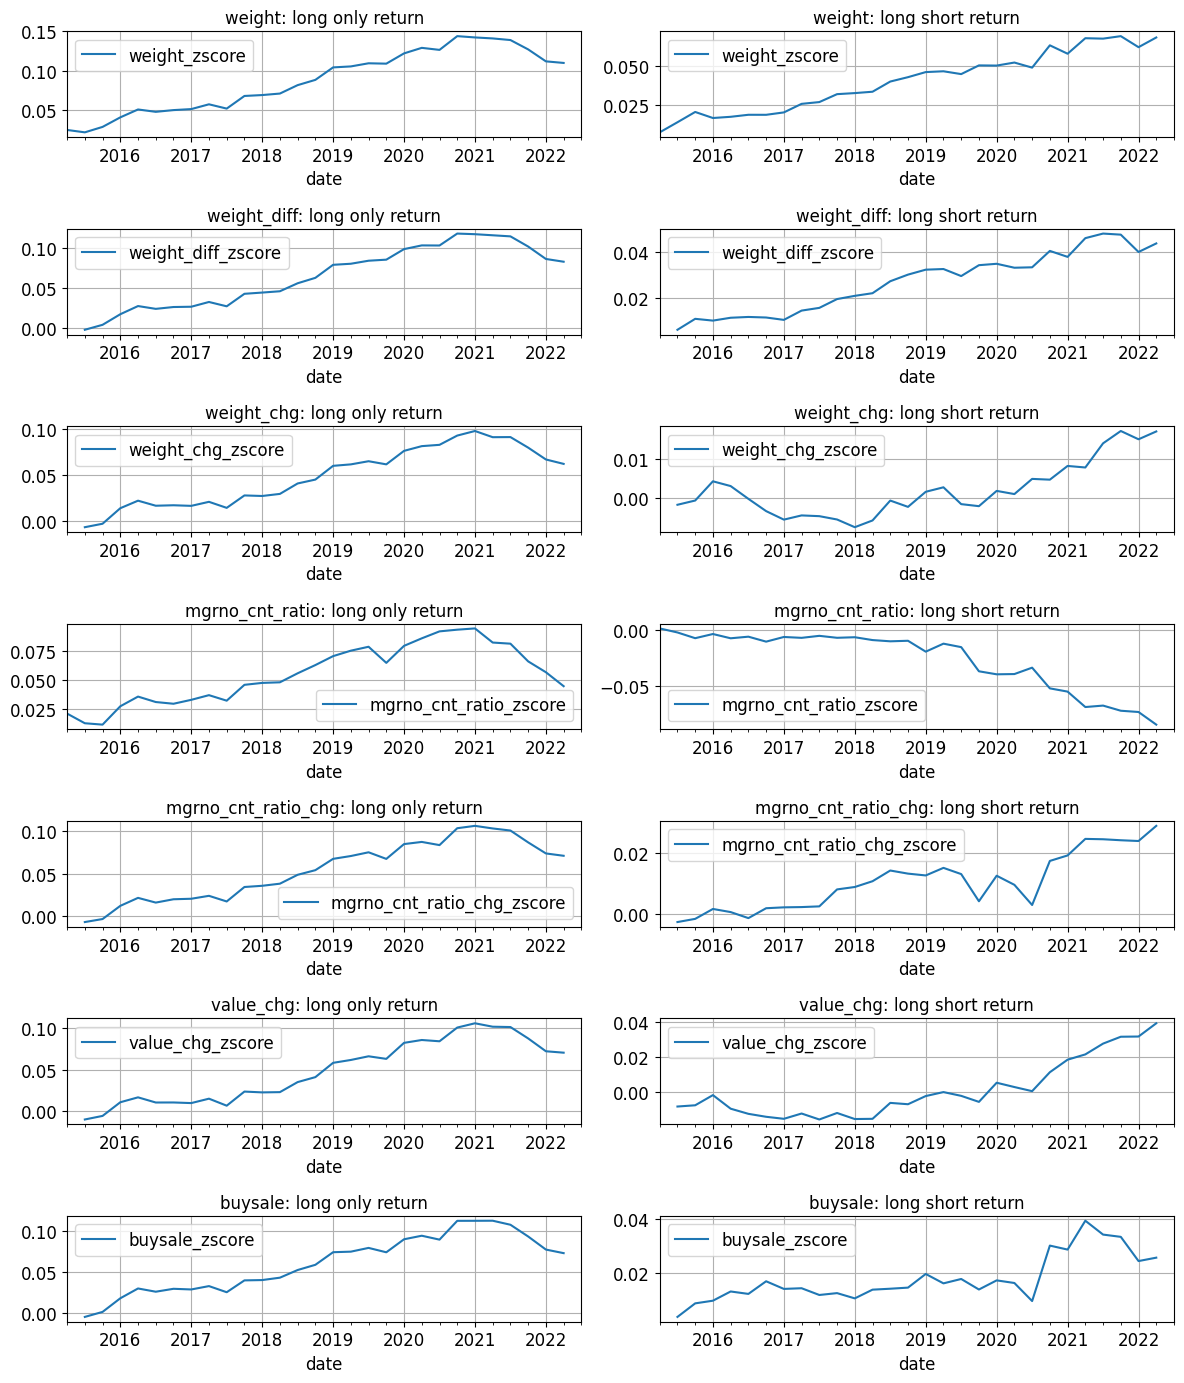

In [96]:
fig, axes = plt.subplots(7, 2, figsize=(12, 14))
for idx, feature in enumerate(features):
    ret2 = holdings_stk.groupby('date').apply(get_long_only_returns, signal_col=f"{feature}_zscore", perc=0.2, ret='future_ret').cumsum().to_frame().rename(columns= {0: f"{feature}_zscore"})
    ret2.plot(ax = axes[idx][0], grid = True, title=f"{feature}: long only return")
    ret2 = holdings_stk.groupby('date').apply(get_long_short_returns, signal_col=f"{feature}_zscore", perc=0.2, ret='future_ret').cumsum().to_frame().rename(columns= {0: f"{feature}_zscore"})
    ret2.plot(ax = axes[idx][1], grid = True, title=f"{feature}: long short return")
plt.tight_layout()

In [97]:
stats_long_only = []
stats_long_short = []

for feature in features:
    ret2 = holdings_stk.groupby('date').apply(get_long_only_returns, signal_col=f"{feature}_zscore", perc=0.2, ret='future_ret').to_frame().rename(columns= {0: f"{feature}_zscore"}).dropna()
    stats_long_only.append(backtest(ret2, feature))
    ret2 = holdings_stk.groupby('date').apply(get_long_short_returns, signal_col=f"{feature}_zscore", perc=0.2, ret='future_ret').to_frame().rename(columns= {0: f"{feature}_zscore"}).dropna()
    stats_long_short.append(backtest(ret2, feature))
    
perf = pd.concat(stats_long_short).loc[['weight_zscore', 'weight_diff_zscore', 'value_chg_zscore', 'mgrno_cnt_ratio_chg_zscore']].T
perf.columns = ['weight', 'weight_diff', 'value_chg', 'mgrno_cnt_ratio_chg']
perf

,weight,weight_diff,value_chg,mgrno_cnt_ratio_chg
start_date,2015-06-30,2015-09-30,2015-09-30,2015-09-30
end_date,2022-06-30,2022-06-30,2022-06-30,2022-06-30
n_quarter,29,28,28,28
n_pos_quarter,21,20,16,16
ret_annual,0.009478,0.006242,0.005575,0.004111
std_annual,0.009267,0.00672,0.01015,0.008828
shape,1.022709,0.928787,0.549328,0.465716
mdd,0.007139,0.007993,0.013778,0.01211


## visualization

In [98]:
# choose the stock that we care about
stk_focus = ["MICROSOFT CORP", "UNITED HEALTHCARE CORP", 'COSTCO WHOLESALE CORP']
permno_focus = [10107, 87055, 92655]
holdings_stk_focus = holdings_stk[holdings_stk.index.get_level_values(1).isin(permno_focus)].reset_index().set_index(['permno', 'date']).sort_index()

# change datetime index to date
holdings_stk_focus = holdings_stk_focus.reset_index()
holdings_stk_focus['date'] = holdings_stk_focus['date'].dt.date
holdings_stk_focus = holdings_stk_focus.set_index(['permno', 'date'])

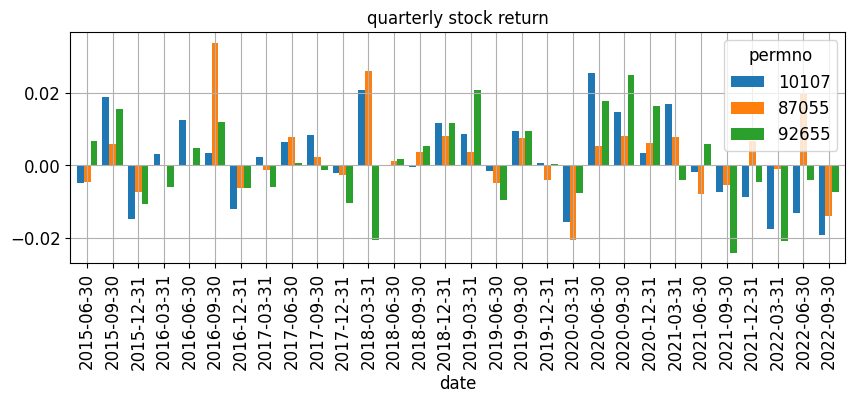

In [99]:
holdings_stk_focus['ret'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'quarterly stock return', width=0.8);

### weight

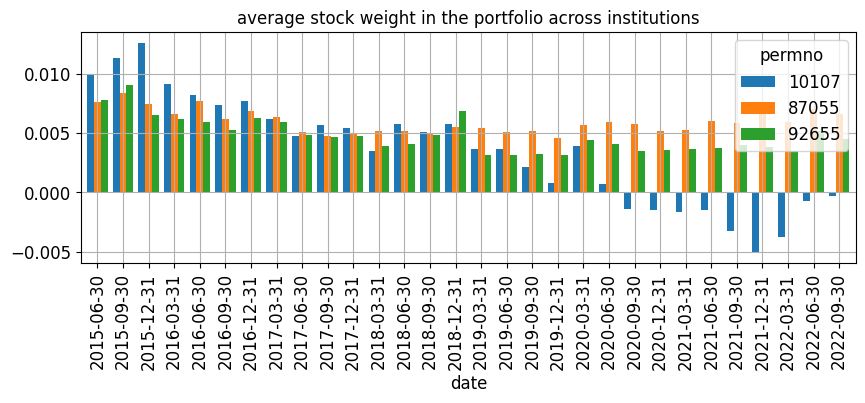

In [100]:
holdings_stk_focus['weight'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average stock weight in the portfolio across institutions', width=0.8);

<Axes: >

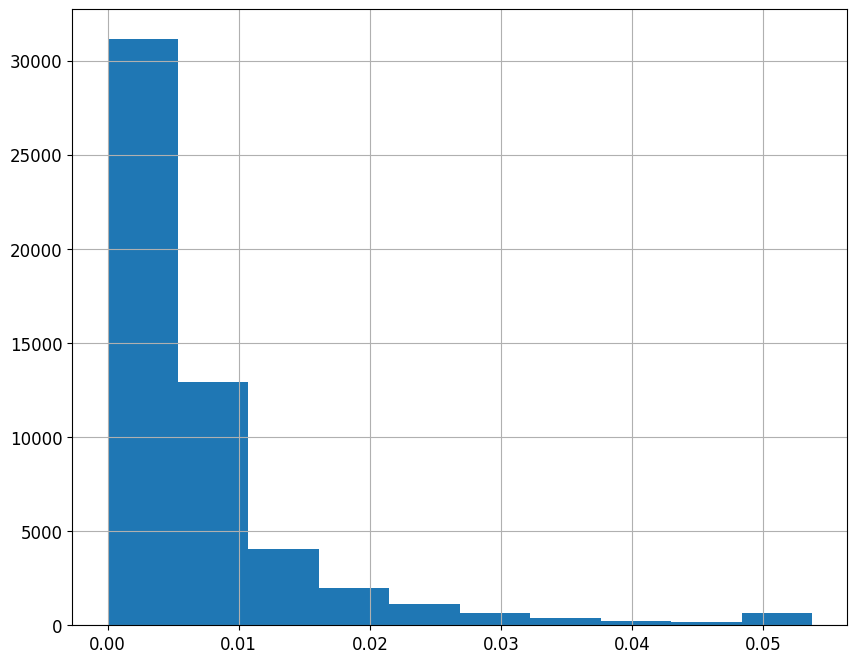

In [101]:
holdings_stk['weight'].clip(0, holdings_stk['weight'].quantile(0.99)).hist()

### weight_diff

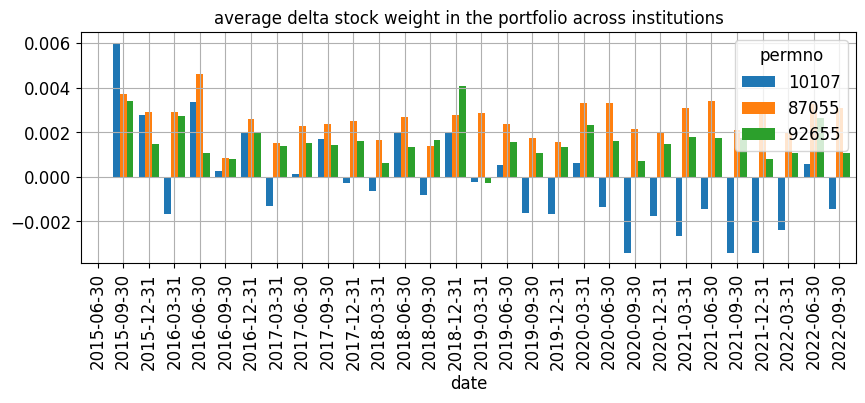

In [102]:
holdings_stk_focus['weight_diff'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average delta stock weight in the portfolio across institutions', width=0.8);

<Axes: >

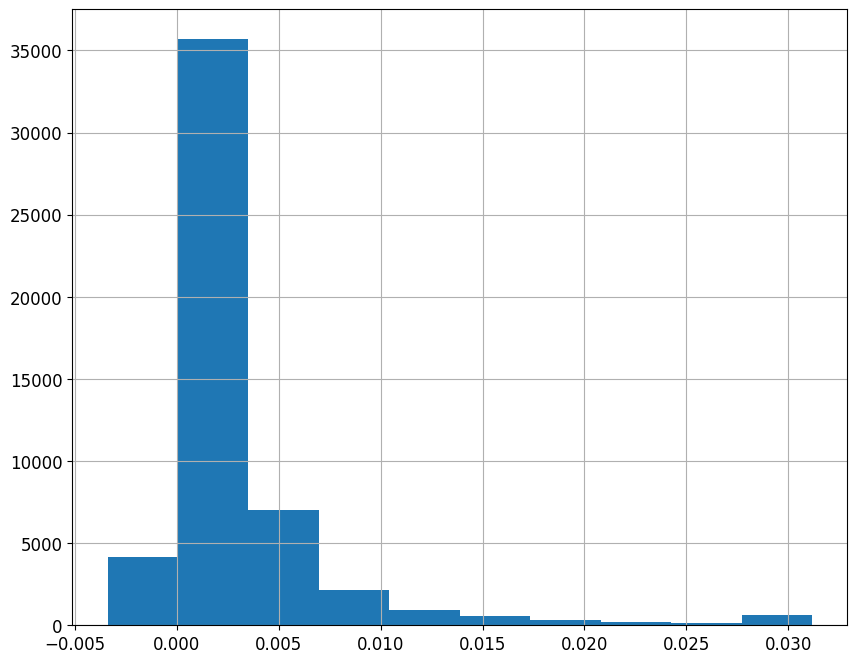

In [103]:
holdings_stk['weight_diff'].hist()

### buysale count

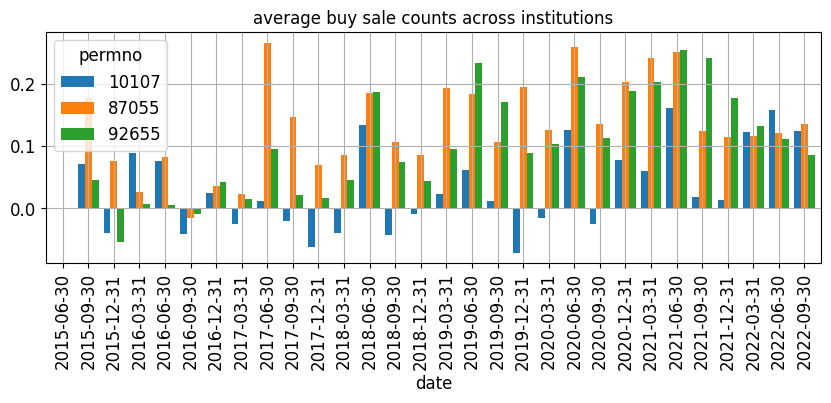

In [104]:
holdings_stk_focus['buysale'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average buy sale counts across institutions', width=0.8);

<Axes: >

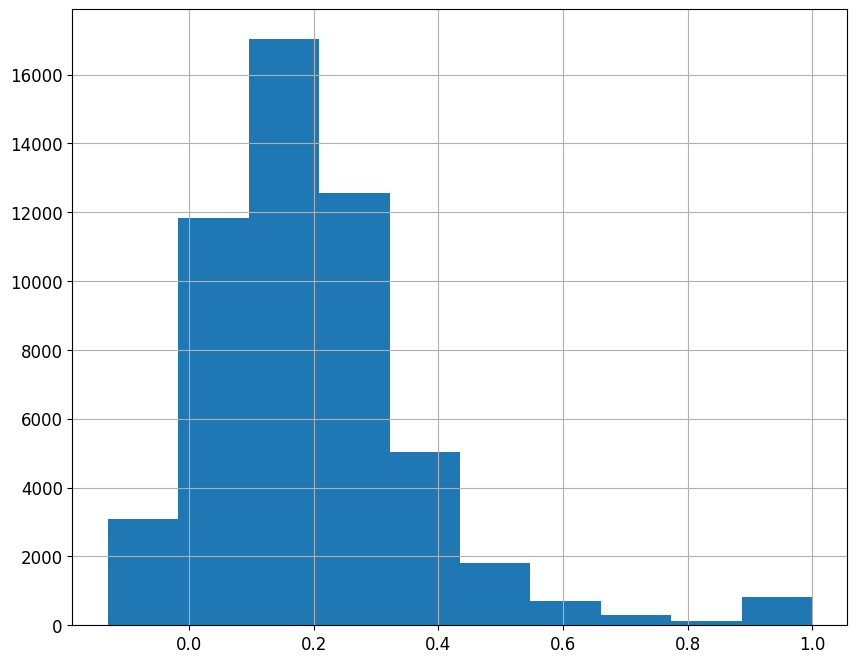

In [105]:
holdings_stk['buysale'].clip(holdings_stk['buysale'].quantile(0.01), holdings_stk['buysale'].quantile(0.99)).hist()

### mgrno_cnt_ratio_chg

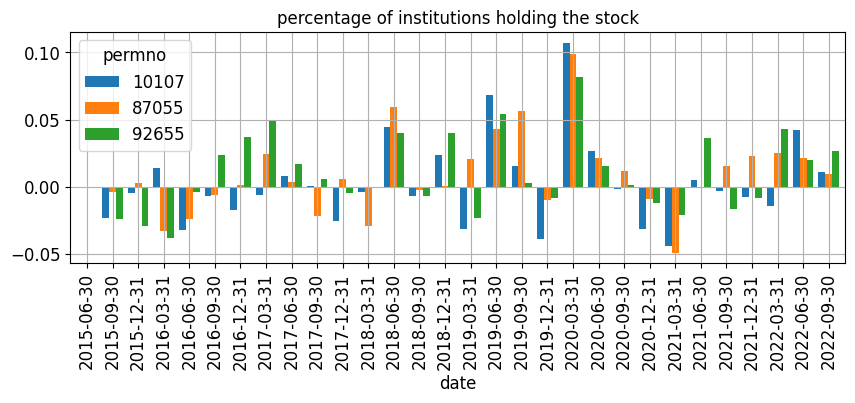

In [106]:
holdings_stk_focus['mgrno_cnt_ratio_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'percentage of institutions holding the stock', width=0.8);

<Axes: >

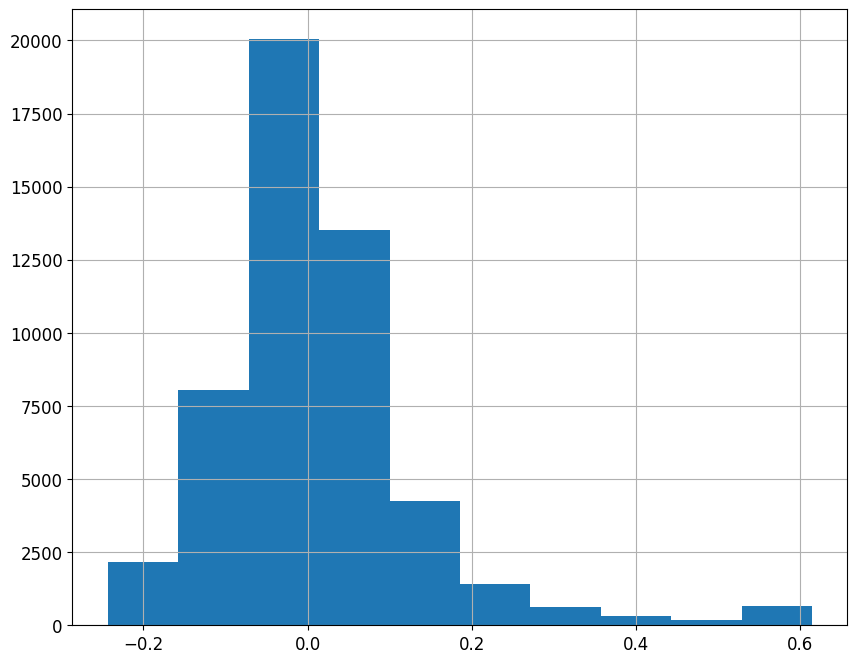

In [107]:
holdings_stk['mgrno_cnt_ratio_chg'].clip(holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.01), holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.99)).hist()

### value change

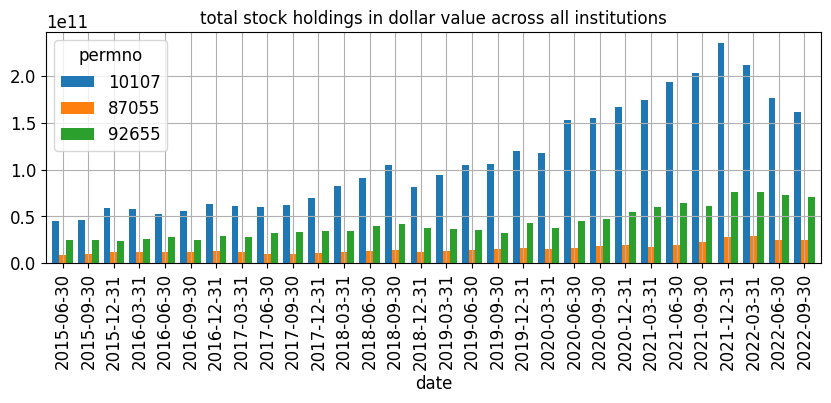

In [108]:
holdings_stk_focus['total_value'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'total stock holdings in dollar value across all institutions', width=0.8);

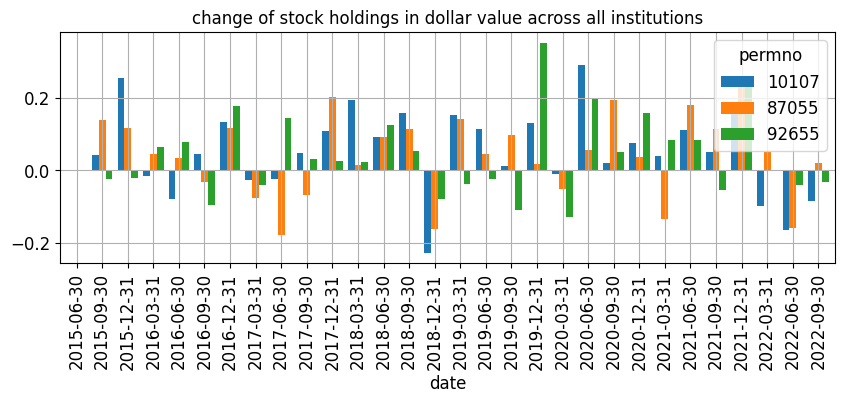

In [109]:
holdings_stk_focus['value_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'change of stock holdings in dollar value across all institutions', width=0.8);

<Axes: >

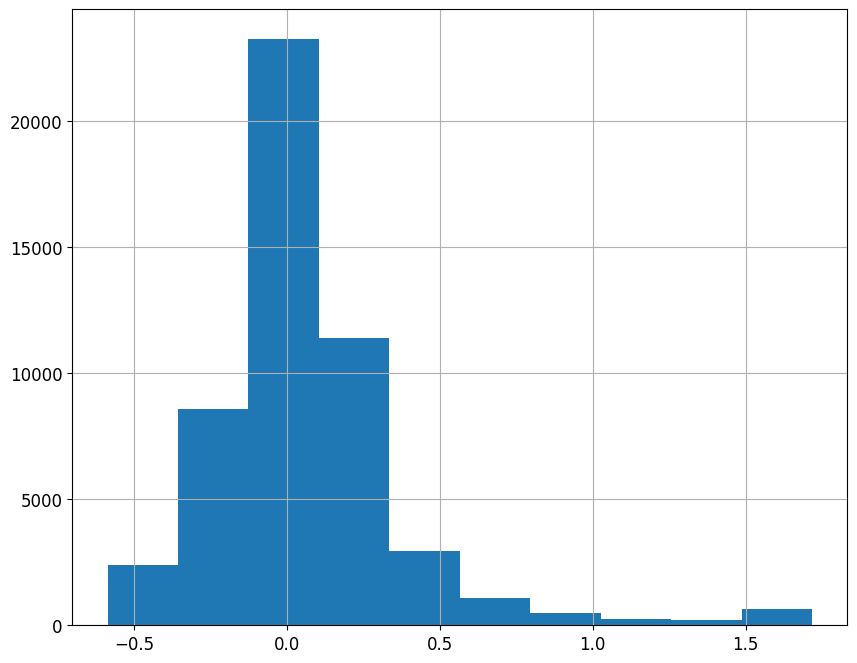

In [110]:
holdings_stk['value_chg'].clip(holdings_stk['value_chg'].quantile(0.01), holdings_stk['value_chg'].quantile(0.99)).hist()

# Factor research

In [111]:
pv_file_path = '../data/price_vol_gics_all.parquet.gzip'
pv_data = pd.read_parquet(pv_file_path)

factor_file_path = '../data/factor_all.parquet.gzip'
factor_data = pd.read_parquet(factor_file_path)

signal_df = holdings_stk.reset_index().merge(factor_data, on=['date', 'permno'], how='left')
signal_df.dropna(inplace=True)

In [112]:
from function_lib import *
import warnings
warnings.filterwarnings("ignore")
plt.rc('figure', figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
df_to_parquet(signal_df, 'signal_df')

correlation decay RunTime: 0.0252 seconds


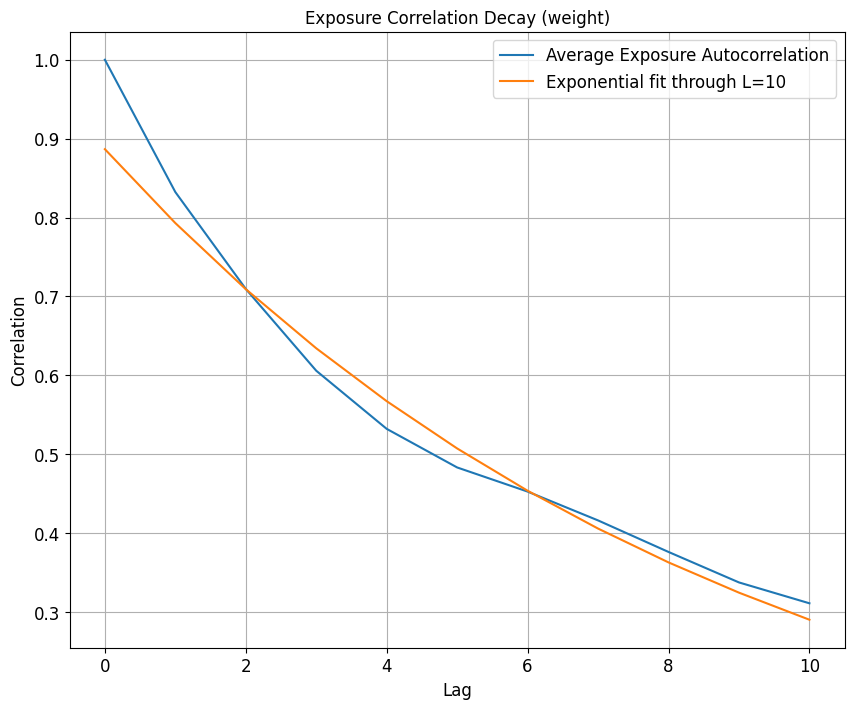

correlation decay RunTime: 0.0258 seconds


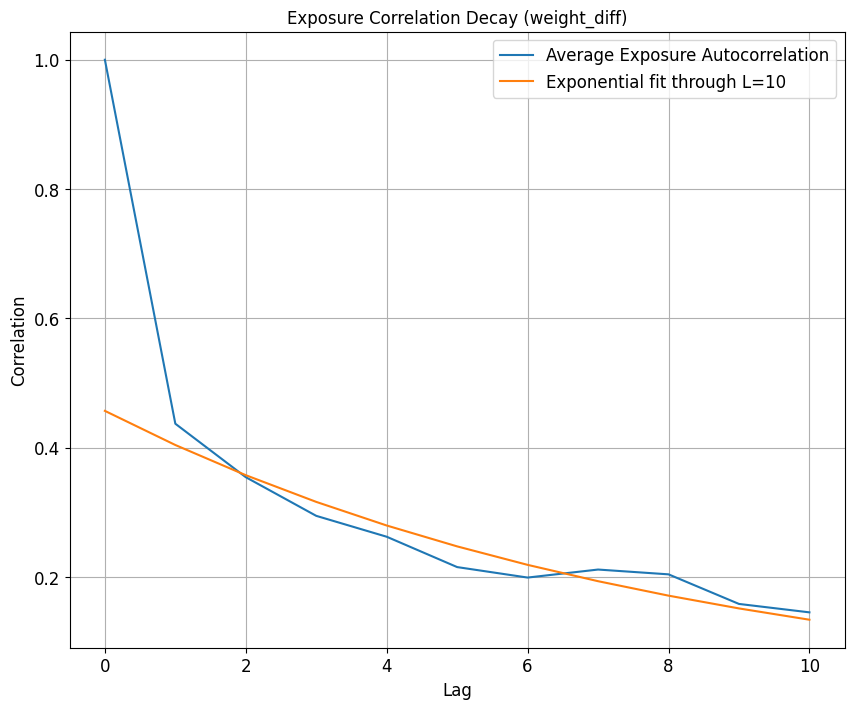

correlation decay RunTime: 0.0275 seconds


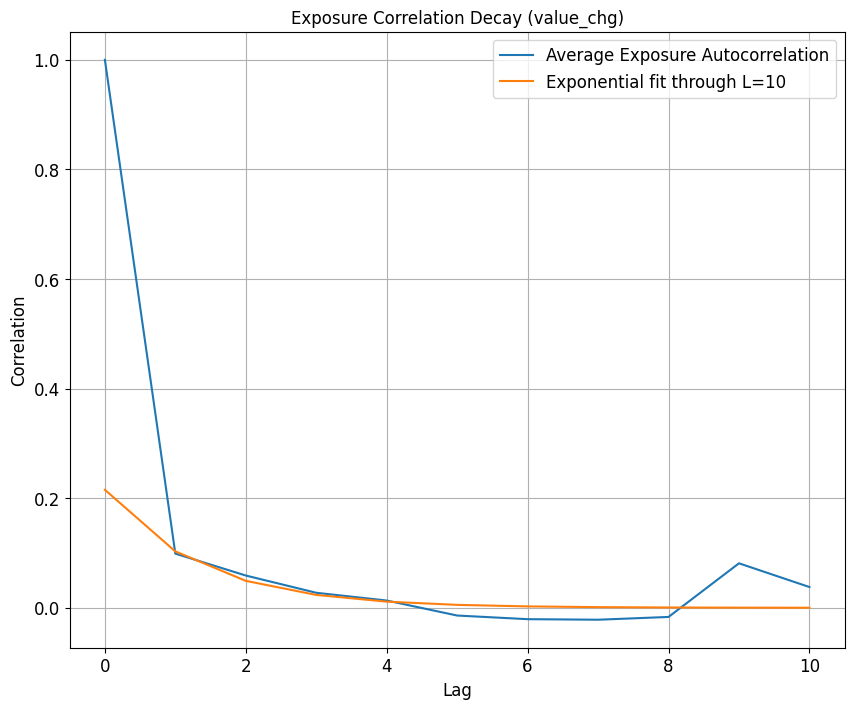

correlation decay RunTime: 0.0303 seconds


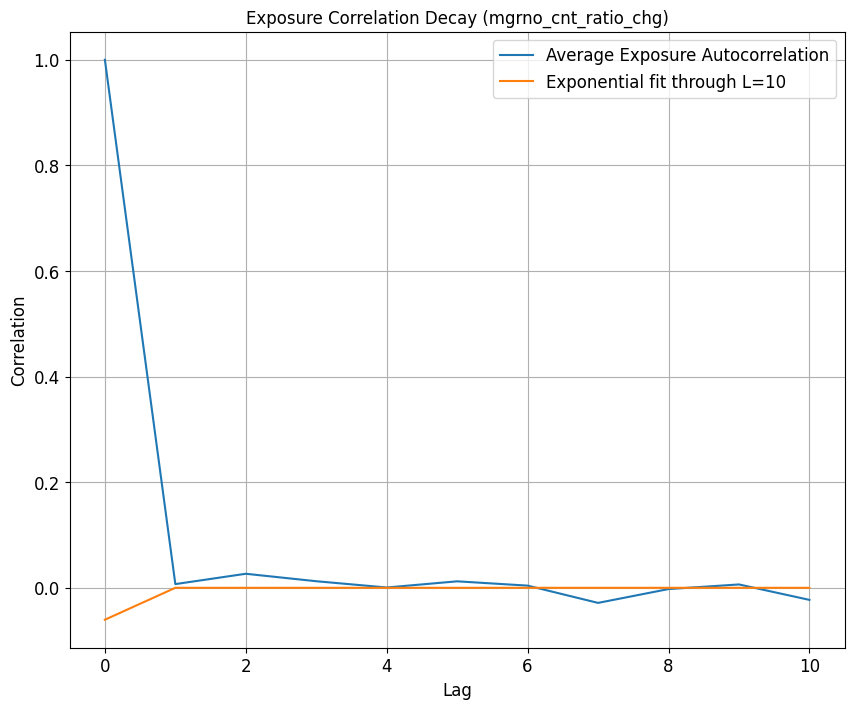

In [114]:
signal_cols = ['weight', 'weight_diff', 'value_chg', 'mgrno_cnt_ratio_chg']
#signal_cols = 'value_chg'

"""
rvolhl_21d, The high-low return volatility (rvolhl_21d)
betadown_252d Downside beta (betadown_252d)
'ivol_ff3_21d', 'iskew_ff3_21d'. Idiosyncratic volatility & skewness from the Fama-French 3-factor model 
"""

risk_factors = ['dolvol', 'div12m_me', 'ret_1_0', 'ret_6_1', 'ret_12_1', 'ret_60_12',
              'at_gr1', 'ebit_sale', 'ebit_bev', 'sale_bev', 'niq_be', 'niq_su', 'ni_ar1', 'beta_60m', 
              'ami_126d', 'betadown_252d', 'rvolhl_21d'
]
ret_col = 'future_ret'
c.DATE = 'date'
c.SEC_ID = 'permno'
c.FREQUENCY = 'Q'

def prepare_signal(df, risk_factors, factors, group_cols = [c.SEC_ID]):
    """
    Normalize signals; risk_factors and factors are lists
    """
    security_df = df.copy()
    security_df.dropna(subset=risk_factors + factors, inplace=True)
    security_df.sort_values(by=c.DATE, inplace=True)
    security_df = get_z_scores(security_df, factors, suffix='_z')
    
    for signal in factors:
        security_df = orthogonalize_signals(security_df, [signal], risk_factors, by=c.DATE, suffix='_Resid')
    
    z_scored_list = [z for z in security_df.columns if z.endswith('_z') or z.endswith('_Resid')]
    return security_df, z_scored_list

signal_df = read_cache('signal_df')
signal_df, z_scored_y = prepare_signal(signal_df, risk_factors=risk_factors, factors=[ret_col])
signal_df, z_scored_features = prepare_signal(signal_df, risk_factors=risk_factors, factors=signal_cols)

df_to_parquet(signal_df, 'factor_neutralized_df')

signal_df.rename(columns={f'{ret_col}_Resid': 'AlphaReturn', f'{ret_col}_z': 'ExMktReturn',
                          'ivol_ff3_21d': 'InvSpecRisk'}, inplace=True)
# trade_df = signal_df.copy()  # can add other filters
signal_df.dropna(inplace=True)

# return_cols = ['ExMktReturn', 'AlphaReturn']
for signal in signal_cols:
    # z-scored signal backtest for residualized return
    # factor portfolio using WLS, with InvSpecRisk as the weight
    result_df = run_backtest(signal_df, signal_col=signal, return_col=['AlphaReturn'], lags=[0, 1, 2, 3, 4, 5])

correlation decay RunTime: 0.0255 seconds


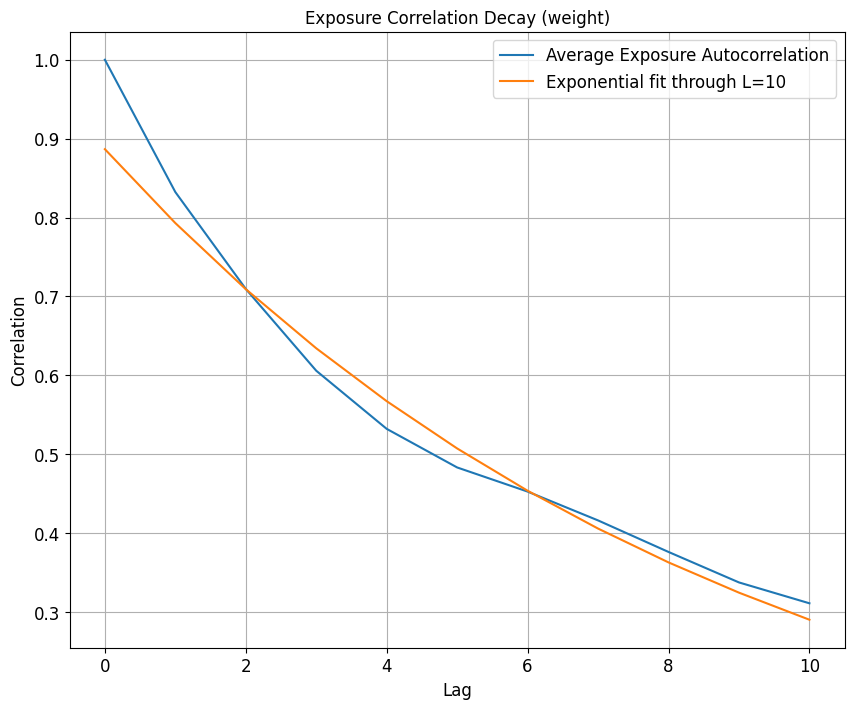

correlation decay RunTime: 0.0275 seconds


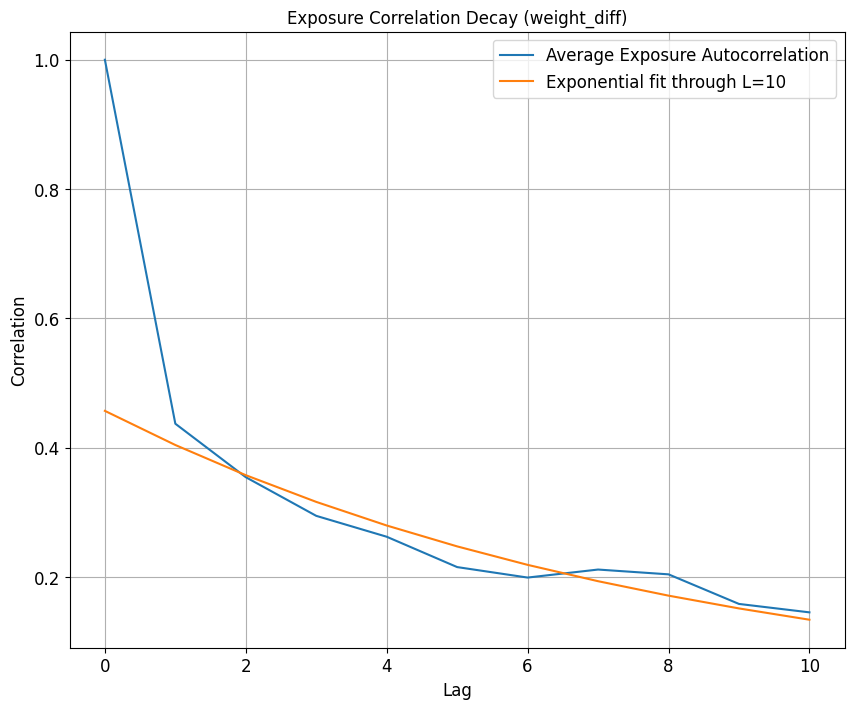

correlation decay RunTime: 0.0264 seconds


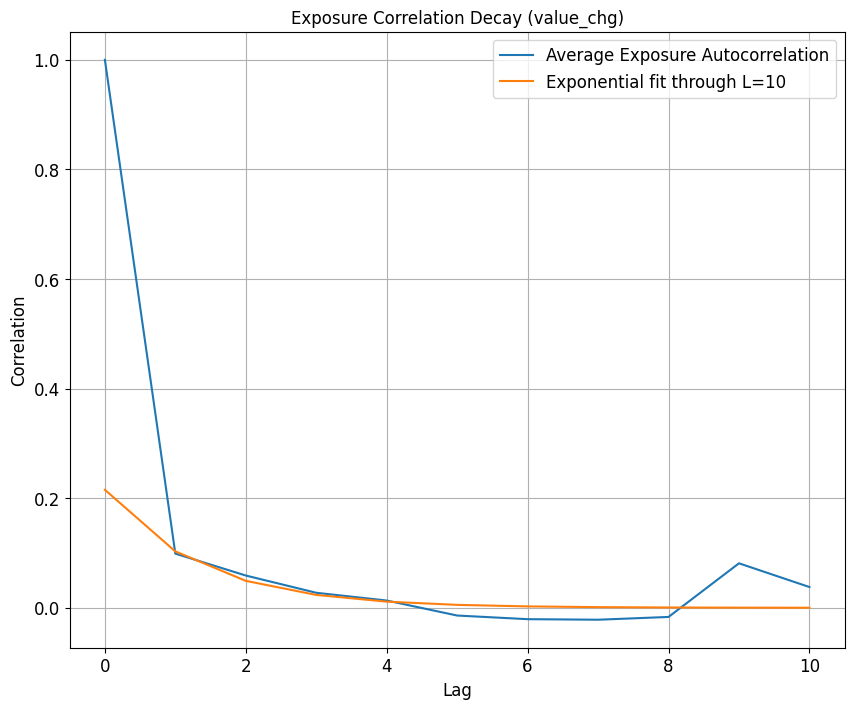

correlation decay RunTime: 0.0282 seconds


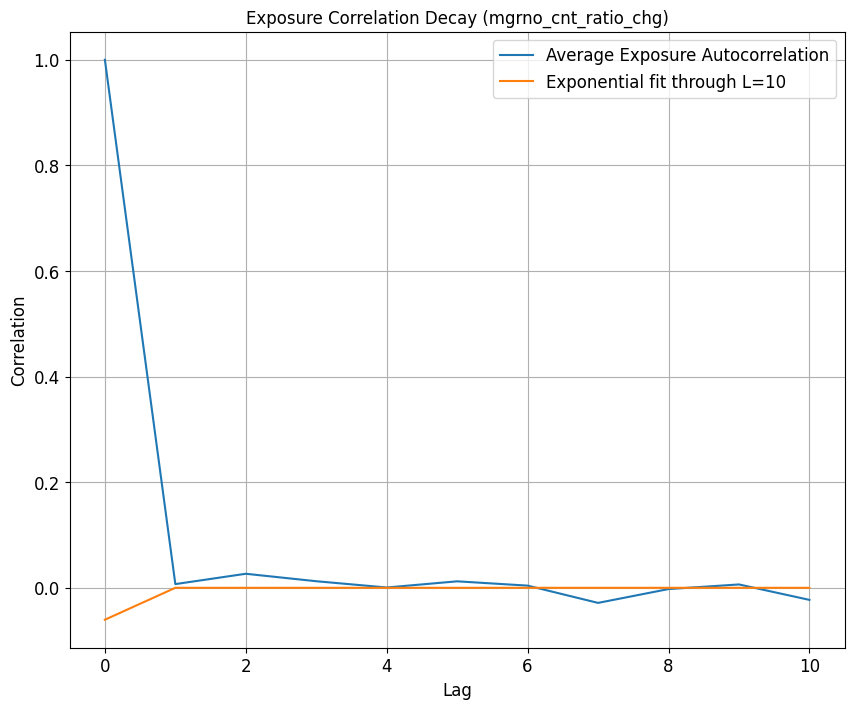

In [115]:
# Factor regression using OLS. no weight
for signal in signal_cols:
    result_df = run_backtest(signal_df, signal_col=signal, return_col=['AlphaReturn'], lags=[0, 1, 2, 3, 4, 5], WLS_model=False)

In [116]:
risk_factors = ['future_ret', 'dolvol', 'div12m_me', 'ret_1_0', 'ret_6_1', 'ret_12_1', 'ebit_sale', 'ebit_bev', 'beta_60m', 
              'ami_126d', 'betadown_252d', 'rvolhl_21d']
hmap = build_corr_heatmap(signal_df, others=risk_factors, factors=signal_cols)
styled_df = Table(round(hmap, 1), title=f'Rank Corr of Factors & Risk Factors (%)', number_fmt="{:.1f}")
display(styled_df)

,weight,weight_diff,value_chg,mgrno_cnt_ratio_chg
weight,100.0,67.5,10.9,6.9
weight_diff,67.5,100.0,20.8,6.7
value_chg,10.9,20.8,100.0,32.7
mgrno_cnt_ratio_chg,6.9,6.7,32.7,100.0
future_ret,3.4,2.3,1.3,1.0
dolvol,18.7,22.3,1.5,6.4
div12m_me,-20.5,-10.5,-6.5,-5.7
ret_1_0,5.1,11.3,41.0,0.2
ret_6_1,12.3,2.9,40.0,39.6
ret_12_1,13.5,2.4,26.0,33.3
